In [1]:
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
import pandas as pd

savedata = 1 # Save Netpyne and BBP soma_voltage

In [2]:
!nrnivmodl mod/

/home/fernando/Dropbox/Human_L23_NetPyNE
Mod files: "mod/mod//CaDynamics.mod" "mod/mod//Ca_HVA.mod" "mod/mod//Ca_LVA.mod" "mod/mod//epsp.mod" "mod/mod//Gfluct.mod" "mod/mod//Ih.mod" "mod/mod//Im.mod" "mod/mod//K_P.mod" "mod/mod//K_T.mod" "mod/mod//Kv3_1.mod" "mod/mod//Nap.mod" "mod/mod//NaTg.mod" "mod/mod//NMDA.mod" "mod/mod//ProbAMPANMDA_EMS.mod" "mod/mod//ProbAMPANMDA.mod" "mod/mod//ProbGABAAB_EMS.mod" "mod/mod//ProbUDFsyn.mod" "mod/mod//SK.mod" "mod/mod//tonic.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [3]:
from netpyne import sim, specs
import pickle

cfg = specs.SimConfig()     

cfg.duration = 2000 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -80}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['HL23PYR', 'HL23VIP', 'HL23PV', 'HL23SST']

cfg.recordCells = allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'},
                    'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},                  
                    'V_dend_5': {'sec':'dend_5', 'loc':0.5, 'var':'v'},
                    }


## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.025      

cfg.simLabel = 'L23_Net'
cfg.saveFolder = '.'
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData' , 'simConfig', 'netParams', 'netParams']
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			##  
cfg.saveCellConns = True		##  

cfg.analysis['plotTraces'] = {'include': allpops, 'figSize': (12, 4), 'timeRange': [0,cfg.duration], 'saveFig': False, 'overlay': True, 'oneFigPer': 'cell'}  # Plot recorded traces for this list of cells


#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 0

cfg.IClamp1 = {'pop': 'HL23PYR',  'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': 100, 'amp': 0.1}
# cfg.IClamp2 = {'pop': 'HL23VIP', 'sec': 'soma_0', 'loc': 0.5, 'start': 100, 'dur': 300, 'amp': 0.1}
# cfg.IClamp3 = {'pop': 'HL23PV', 'sec': 'soma_0', 'loc': 0.5, 'start': 100, 'dur': 300, 'amp': 0.1}
# cfg.IClamp4 = {'pop': 'HL23SST', 'sec': 'soma_0', 'loc': 0.5, 'start': 100, 'dur': 300, 'amp': 0.1}

In [4]:
#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

# L23 Human net
# #              L2/3   L4     L5
PYRmaxApics = [550   ,1550   ,1900]
uppers =      [-250  ,-1200 ,-1600]
lowers =      [-1200 ,-1580 ,-2300]

L25_human = 250 + 950 + 380 + 720 + 1000
Human_height = 3300.0

netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
cfg.scale = 1.0 # reduce size
cfg.sizeY = 3300.0
cfg.sizeX = 50.0 # r = 25 um ??? find it
cfg.sizeZ = 50.0

netParams.scale = cfg.scale # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume
   
cellModels = ['HH_full']

Ipops = ['HL23VIP', 'HL23PV', 'HL23SST']
Epops = ['HL23PYR']

layer = {'1':[0.0, 250.0], '23': [250.0,1200.0], '23soma': [550.0,1200.0], '4':[1200.0,1580.0], '5': [1580.0,2300.0], '6': [2300.0,3300.0]}  # normalized layer boundaries

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------

for cellName in allpops:
    cellRule = netParams.importCellParams(label=cellName, somaAtOrigin=True,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper.py',
        cellName='loadCell_' + cellName,
        cellInstance = True,
        cellArgs={'cellName': cellName})

NeuronTemplate_HL23PYR[0]
NeuronTemplate_HL23VIP[0]
NeuronTemplate_HL23PV[0]
NeuronTemplate_HL23SST[0]


## Load cells and circuit informations from table

In [5]:
#Import Excel file
circuit_params = pd.read_excel('Circuit_param.xls', sheet_name = None, index_col = 0)

#Get cell names and import biophys
cell_names = [i for i in circuit_params['conn_probs'].axes[0]]

circuit_params["syn_params"] = {'none':{'tau_r_AMPA': 0,'tau_d_AMPA': 0,'tau_r_NMDA': 0,
                                'tau_d_NMDA': 0, 'e': 0,'Dep': 0,'Fac': 0,'Use': 0,'u0':0,'gmax': 0}}
circuit_params["multi_syns"] = {'none':{'loc':0,'scale':0}}
# organizing dictionary for LFPY input
for pre in cell_names:
    for post in cell_names:
        if "PYR" in pre:
            circuit_params["syn_params"][pre+post] = {'tau_r_AMPA': 0.3, 'tau_d_AMPA': 3, 'tau_r_NMDA': 2,
                                                      'tau_d_NMDA': 65, 'e': 0, 'u0':0,
                                                      'Dep': circuit_params["Depression"].at[pre, post],
                                                      'Fac': circuit_params["Facilitation"].at[pre, post],
                                                      'Use': circuit_params["Use"].at[pre, post],
                                                      'gmax': circuit_params["syn_cond"].at[pre, post]}
        else:
            circuit_params["syn_params"][pre+post] = {'tau_r': 1, 'tau_d': 10, 'e': -80, 'u0':0,
                                                      'Dep': circuit_params["Depression"].at[pre, post],
                                                      'Fac': circuit_params["Facilitation"].at[pre, post],
                                                      'Use': circuit_params["Use"].at[pre, post],
                                                      'gmax': circuit_params["syn_cond"].at[pre, post]}
        circuit_params["multi_syns"][pre+post] = {'loc':int(circuit_params["n_cont"].at[pre, post]),'scale':0}


stimuli = []
for stimulus in circuit_params['STIM_PARAM'].axes[0]:
    stimuli.append({})
    for param_name in circuit_params['STIM_PARAM'].axes[1]:
        stimuli[-1][param_name] = circuit_params['STIM_PARAM'].at[stimulus, param_name]
    new_param = circuit_params["syn_params"][stimuli[-1]['syn_params']].copy()
    new_param['gmax'] = stimuli[-1]['gmax']
    stimuli[-1]['new_param'] = new_param

In [6]:
cell_names

['HL23PYR', 'HL23SST', 'HL23PV', 'HL23VIP']

In [7]:
circuit_params.keys()

dict_keys(['conn_probs', 'syn_cond', 'n_cont', 'Depression', 'Facilitation', 'Use', 'Syn_pos', 'SING_CELL_PARAM', 'STIM_PARAM', 'syn_params', 'multi_syns'])

In [8]:
circuit_params['SING_CELL_PARAM']

,HL23PYR,HL23SST,HL23PV,HL23VIP
GOU,0.000028,0.000030,0.000280,0.000066
norm_tonic,0.000938,0.000938,0.000938,0.000938
drug_tonic,0.001352,0.001030,0.001091,0.000938
apic_tonic,0.000938,0.000938,0.000938,0.000938
drug_apic_tonic,0.001352,0.001030,0.001091,0.000938
cell_num,800.000000,50.000000,70.000000,80.000000
rotate_x,1.570000,1.770000,1.260000,-1.570000
rotate_y,2.620000,2.770000,2.570000,3.570000


In [9]:
from scipy import stats as st

halfnorm_rv = st.halfnorm
uniform_rv = st.uniform

#              L2/3   L4     L5
PYRmaxApics = [550   ,1550   ,1900]
uppers =      [-250  ,-1200 ,-1600]
lowers =      [-1200 ,-1580 ,-2300]

depths = []
rangedepths = []
minSynLocs = []
syn_pos = []
pop_args = {}

for i in range (3):
    depths.append((lowers[i]-uppers[i])/2-PYRmaxApics[i])
    rangedepths.append(abs(lowers[i]-uppers[i])/2)
    minSynLocs.append((lowers[i]-uppers[i])/2*3-PYRmaxApics[i])

    syn_pos.append({'section' : ['apic', 'dend'],
                    'fun' : [uniform_rv, halfnorm_rv],
                    'funargs' : [{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])},{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])}],
                    'funweights' : [1, 1.]})
    syn_pos.append({'section' : ['apic'],
                    'fun' : [uniform_rv],
                    'funargs' : [{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])}],
                    'funweights' : [1.]})
    syn_pos.append({'section' : ['dend'],
                    'fun' : [uniform_rv],
                    'funargs' : [{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])}],
                    'funweights' : [1.]})
    syn_pos.append({'section' : ['dend'],
                   'fun' : [halfnorm_rv],
                   'funargs' : [{'loc':minSynLocs[i], 'scale':abs(minSynLocs[i])}],
                   'funweights' : [1.]})
    names = ['HL2','HL4','HL5']
    pop_args[names[i]]={'radius':250,
                        'loc':depths[i],
                        'scale':rangedepths[i]*4,
                        'cap':rangedepths[i]}


In [10]:
depths, minSynLocs,rangedepths,syn_pos[0]['section'],pop_args['HL2']


([-1025.0, -1740.0, -2250.0],
 [-1975.0, -2120.0, -2950.0],
 [475.0, 190.0, 350.0],
 ['apic', 'dend'],
 {'radius': 250, 'loc': -1025.0, 'scale': 1900.0, 'cap': 475.0})

## Rotate the cells

In [11]:
# ----------------------------------------------------------------------------------------------------------------------- #
# Rotate to z as vertical
# ----------------------------------------------------------------------------------------------------------------------- #

rotate_x = {}
rotate_y = {}
rotate_z = {}
rotate_x['HL23PYR'], rotate_x['HL23SST'], rotate_x['HL23PV'], rotate_x['HL23VIP'] = 1.57, 1.77, 1.26, -1.57
rotate_y['HL23PYR'], rotate_y['HL23SST'], rotate_y['HL23PV'], rotate_y['HL23VIP'] = 2.62, 2.77, 2.57, 3.57
rotate_z['HL23PYR'], rotate_z['HL23SST'], rotate_z['HL23PV'], rotate_z['HL23VIP'] = 0.0, 0.0, 0.0, 0.0


for cellName in netParams.cellParams.keys():

    cellType = netParams.cellParams[cellName]['conds']['cellType']

    x = rotate_x[cellType]
    y = rotate_y[cellType]
    z = rotate_z[cellType]

    for sectName in netParams.cellParams[cellName]['secs'].keys():

        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        theta = -x
        rotation_x = np.array([[1, 0, 0],
                                       [0, np.cos(theta), -np.sin(theta)],
                                       [0, np.sin(theta), np.cos(theta)]])
        
        # print(cellName,sectName,len(sectParams_new))
        # print(sectParams_new)       
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_x)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        phi = -y
        rotation_y = np.array([[np.cos(phi), 0, np.sin(phi)],
                                       [0, 1, 0],
                                       [-np.sin(phi), 0, np.cos(phi)]])
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_y)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        gamma = -z
        rotation_z = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                                       [np.sin(gamma), np.cos(gamma), 0],
                                       [0, 0, 1]])
    
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_z)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams

# ----------------------------------------------------------------------------------------------------------------------- #
# Rotate to Y as vertical axis
# ----------------------------------------------------------------------------------------------------------------------- #

rotate_x = {}
rotate_y = {}
rotate_z = {}
rotate_x['HL23PYR'], rotate_x['HL23SST'], rotate_x['HL23PV'], rotate_x['HL23VIP'] = -1.5708, -1.5708, -1.5708, -1.5708
rotate_y['HL23PYR'], rotate_y['HL23SST'], rotate_y['HL23PV'], rotate_y['HL23VIP'] = 0.0, 0.0, 0.0, 0.0
rotate_z['HL23PYR'], rotate_z['HL23SST'], rotate_z['HL23PV'], rotate_z['HL23VIP'] = 0.0, 0.0, 0.0, 0.0


for cellName in netParams.cellParams.keys():

    cellType = netParams.cellParams[cellName]['conds']['cellType']

    x = rotate_x[cellType]
    y = rotate_y[cellType]
    z = rotate_z[cellType]

    for sectName in netParams.cellParams[cellName]['secs'].keys():

        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        theta = -x
        rotation_x = np.array([[1, 0, 0],
                                       [0, np.cos(theta), -np.sin(theta)],
                                       [0, np.sin(theta), np.cos(theta)]])
        
        # print(cellName,sectName,len(sectParams_new))
        # print(sectParams_new)       
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_x)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        phi = -y
        rotation_y = np.array([[np.cos(phi), 0, np.sin(phi)],
                                       [0, 1, 0],
                                       [-np.sin(phi), 0, np.cos(phi)]])
        
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_y)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams


        sectParams_new = netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d']
        sectParams = []

        gamma = -z
        rotation_z = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                                       [np.sin(gamma), np.cos(gamma), 0],
                                       [0, 0, 1]])
    
        for i in range(len(sectParams_new)):
            x3d, y3d, z3d, L3d = sectParams_new[i]
            rel_pos = x3d, y3d, z3d

            # print(rel_pos)        
            rel_pos = np.dot(rel_pos, rotation_z)
            # print(rel_pos)
            pt3d = (rel_pos[0],rel_pos[1] , rel_pos[2], L3d)
            sectParams.append(pt3d)

        netParams.cellParams[cellName]['secs'][sectName]['geom']['pt3d'] = sectParams

## Change axon names

In [12]:
#------------------------------------------------------------------------------
# Cell parameters 
#------------------------------------------------------------------------------

for cellName in netParams.cellParams.keys():
        
        axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['soma_0']['geom']['pt3d'][-1]
        axon_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['diam']
        axon_pt3d_L =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['L']

        netParams.cellParams[cellName]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

        axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_0']['geom']['pt3d'][-1]
        axon1_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['diam']
        axon1_pt3d_L =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['L']

        netParams.cellParams[cellName]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)] 
        
        if 'myelin_0' in netParams.cellParams[cellName]['secs'].keys():

                if 'myelin_0' not in netParams.cellParams[cellName]['secLists']['all']:
                        netParams.cellParams[cellName]['secLists']['all'].append('myelin_0')

                if 'myelin_0' not in netParams.cellParams[cellName]['secLists']['axonal']:                        
                        netParams.cellParams[cellName]['secLists']['axonal'].append('myelin_0')

                myelin0_pt3d_x, myelin0_pt3d_y, myelin0_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellName]['secs']['axon_1']['geom']['pt3d'][-1]
                myelin0_pt3d_diam =  netParams.cellParams[cellName]['secs']['myelin_0']['geom']['diam']
                myelin0_pt3d_L =  netParams.cellParams[cellName]['secs']['myelin_0']['geom']['L']

                netParams.cellParams[cellName]['secs']['myelin_0']['geom']['pt3d'] = [(myelin0_pt3d_x, myelin0_pt3d_y, myelin0_pt3d_z, myelin0_pt3d_diam),
                                                                                (myelin0_pt3d_x, myelin0_pt3d_y+myelin0_pt3d_L/2.0, myelin0_pt3d_z, myelin0_pt3d_diam),
                                                                                (myelin0_pt3d_x, myelin0_pt3d_y+myelin0_pt3d_L, myelin0_pt3d_z, myelin0_pt3d_diam)] 
# print and rename
for cellName in netParams.cellParams.keys():

    netParams.renameCellParamsSec(label=cellName, oldSec='myelin_0', newSec='axon_2')      
           
    for secname2 in netParams.cellParams[cellName]['secLists'].keys():
     if 'myelin_0' in netParams.cellParams[cellName]['secLists'][secname2]:
       print('old ->',cellName,secname2,netParams.cellParams[cellName]['secLists'][secname2][-1])
       netParams.cellParams[cellName]['secLists'][secname2][-1] = 'axon_2'    
       print('new ->',cellName,secname2,netParams.cellParams[cellName]['secLists'][secname2][-1])

old -> HL23PYR all myelin_0
new -> HL23PYR all axon_2
old -> HL23PYR axonal myelin_0
new -> HL23PYR axonal axon_2
old -> HL23SST all myelin_0
new -> HL23SST all axon_2
old -> HL23SST axonal myelin_0
new -> HL23SST axonal axon_2


## Population parameters

In [13]:

#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
# cell_num = [800, 50, 70, 80]
# cell_num = [19, 2, 2, 2]
# cell_num = [8, 5, 7, 8]
cell_num = [1, 1, 1, 1]

for ii,cellName in enumerate(['HL23PYR', 'HL23SST', 'HL23PV', 'HL23VIP']):
    netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': cell_num[ii], 'yRange': layer['23soma']} 

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}

        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}

        
netParams.rotateCellsRandomly = True

## Create Network

In [14]:
circuit_params.keys()

dict_keys(['conn_probs', 'syn_cond', 'n_cont', 'Depression', 'Facilitation', 'Use', 'Syn_pos', 'SING_CELL_PARAM', 'STIM_PARAM', 'syn_params', 'multi_syns'])

In [15]:
circuit_params['conn_probs']

,HL23PYR,HL23SST,HL23PV,HL23VIP
HL23PYR,0.150,0.19,0.09,0.09
HL23SST,0.190,0.04,0.20,0.06
HL23PV,0.094,0.05,0.37,0.03
HL23VIP,0.000,0.35,0.10,0.05


In [16]:
circuit_params['n_cont']

,HL23PYR,HL23SST,HL23PV,HL23VIP
HL23PYR,3,8,8,4
HL23SST,12,12,13,5
HL23PV,17,16,15,7
HL23VIP,0,9,11,7


In [17]:

# ['HL23PYR', 'HL23SST', 'HL23PV', 'HL23VIP']

# Synaptic mechanism parameters
netParams.synMechParams['AMPA'] = {'mod': 'Exp2Syn', 'tau1': 0.05, 'tau2': 5.3, 'e': 0}  # AMPA
netParams.synMechParams['NMDA'] = {'mod': 'Exp2Syn', 'tau1': 0.15, 'tau2': 15, 'e': 0}  # NMDA
netParams.synMechParams['GABAA'] = {'mod': 'Exp2Syn', 'tau1': 0.07, 'tau2': 9.1, 'e': -80}  # GABAA
netParams.synMechParams['GABAB'] = {'mod': 'Exp2Syn', 'tau1': 0.07, 'tau2': 9.1, 'e': -80}  # GABAB



weightStim = {}
weightStim['HL23PYR'] = 0.0002
weightStim['HL23SST'] = 0.0002
weightStim['HL23PV'] = 0.0005
weightStim['HL23VIP'] = 0.0004

rateStim = {}
rateStim['HL23PYR'] = 100.0
rateStim['HL23SST'] = 100.0
rateStim['HL23PV'] = 100.0
rateStim['HL23VIP'] = 100.0



SourcesNumber = 5 # for each post Mtype - sec distribution

for post in ['HL23PYR', 'HL23VIP', 'HL23PV', 'HL23SST']:

    for qSnum in range(SourcesNumber):
            
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (rateStim[post])/SourcesNumber

            netParams.stimSourceParams['bkg_' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}

            netParams.stimTargetParams['bkg->' + post + '_' + str(qSnum)] = {'source': 'bkg_' + post + '_' + str(qSnum), 'conds': {'pop': [post]}, 'weight': weightStim[post], 'delay': 0.5}

In [18]:
netParams.stimSourceParams, netParams.stimTargetParams

({bkg_HL23PYR_0: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23PYR_1: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23PYR_2: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23PYR_3: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23PYR_4: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23VIP_0: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23VIP_1: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23VIP_2: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23VIP_3: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23VIP_4: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23PV_0: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23PV_1: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23PV_2: {'type': 'NetStim', 'rate': 100, 'noise': 1.0, 'start': 0}, bkg_HL23PV_3: {'type': 'Ne

In [19]:
# print and rename
for cellName in netParams.cellParams.keys():
    print(netParams.cellParams[cellName]['secLists'].keys())
    print(netParams.cellParams[cellName]['secLists']['basal'])
    print(netParams.cellParams[cellName]['secLists']['apical'])
    netParams.cellParams[cellName]['secLists']['spiny'] = {}
    nonSpiny = netParams.cellParams[cellName]['secLists']['axonal']
    nonSpiny.append('soma_0')
    netParams.cellParams[cellName]['secLists']['spiny'] = [sec for sec in netParams.cellParams[cellName]['secLists']['all'] if sec not in nonSpiny]
    print(netParams.cellParams[cellName]['secLists']['spiny'])

dict_keys(['SectionList[0]', 'SectionList[1]', 'all', 'somatic', 'basal', 'apical', 'axonal'])
['dend_0', 'dend_1', 'dend_2', 'dend_3', 'dend_4', 'dend_5', 'dend_6', 'dend_7', 'dend_8', 'dend_9', 'dend_10', 'dend_11', 'dend_12', 'dend_13', 'dend_14', 'dend_15', 'dend_16', 'dend_17', 'dend_18', 'dend_19', 'dend_20', 'dend_21', 'dend_22', 'dend_23', 'dend_24', 'dend_25', 'dend_26', 'dend_27', 'dend_28', 'dend_29']
['apic_0', 'apic_1', 'apic_2', 'apic_3', 'apic_4', 'apic_5', 'apic_6', 'apic_7', 'apic_8', 'apic_9', 'apic_10', 'apic_11', 'apic_12', 'apic_13', 'apic_14', 'apic_15', 'apic_16', 'apic_17', 'apic_18', 'apic_19', 'apic_20', 'apic_21', 'apic_22', 'apic_23', 'apic_24', 'apic_25', 'apic_26', 'apic_27', 'apic_28', 'apic_29', 'apic_30', 'apic_31', 'apic_32', 'apic_33', 'apic_34', 'apic_35', 'apic_36', 'apic_37', 'apic_38', 'apic_39', 'apic_40', 'apic_41', 'apic_42', 'apic_43', 'apic_44', 'apic_45', 'apic_46', 'apic_47', 'apic_48', 'apic_49', 'apic_50', 'apic_51', 'apic_52', 'apic_53',

In [20]:

# Connectivity parameters

print(depths, minSynLocs,rangedepths,syn_pos[0]['section'],pop_args['HL2'],'\n\n')

for pre in cell_names:
    for post in cell_names:
        
        Syn_pos = int(circuit_params['Syn_pos'].at[pre, post])


        if circuit_params['conn_probs'].at[pre, post] > 0.0:

            if "PYR" in pre: # Excitatory
                netParams.synMechParams[pre+post] = {'mod': 'ProbAMPANMDA_EMS',
                                                        'tau_r_AMPA': 0.3, 'tau_d_AMPA': 3.0, 'tau_r_NMDA': 2.0,
                                                        'tau_d_NMDA': 65.0,
                                                        'Dep': circuit_params["Depression"].at[pre, post],
                                                        'Fac': circuit_params["Facilitation"].at[pre, post],
                                                        'Use': circuit_params["Use"].at[pre, post]}
            else:
                netParams.synMechParams[pre+post] = {'mod': 'ProbGABAAB_EMS',
                                                    'tau_r_GABAA': 1, 'tau_d_GABAA': 10,
                                                        'Dep': circuit_params["Depression"].at[pre, post],
                                                        'Fac': circuit_params["Facilitation"].at[pre, post],
                                                        'Use': circuit_params["Use"].at[pre, post]}
                

            netParams.connParams[pre + '->' + post] = {'preConds': {'cellType': pre}, 
                                                        'postConds': {'cellType': post},  #  E -> all (100-1000 um) ,'y': [0,5000]
                                                        'probability': circuit_params['conn_probs'].at[pre, post],                  # probability of connection
                                                        'weight': circuit_params['syn_cond'].at[pre, post],         # synaptic weight 
                                                        'delay': 0.5,      # transmission delay (ms) 
                                                        'synMech': pre+post,
                                                        'synsPerConn': int(circuit_params['n_cont'].at[pre, post]),
                                                        'sec': 'spiny',
                                                        }  
             
            if "PYR" in pre and "PYR" in post:
                netParams.connParams[pre + '->' + post]['sec'] = 'spiny'
            else:
                if 'dend' in syn_pos[Syn_pos]['section']:
                    netParams.connParams[pre + '->' + post]['sec'] = 'basal'
                if 'apic' in syn_pos[Syn_pos]['section']:
                    netParams.connParams[pre + '->' + post]['sec'] = 'apical'

            print('\n',pre+post,circuit_params['n_cont'].at[pre, post],circuit_params['conn_probs'].at[pre, post],Syn_pos,syn_pos[Syn_pos]['section'])
            print(netParams.synMechParams[pre+post])
            print(netParams.connParams[pre + '->' + post])
            print(netParams.connParams[pre + '->' + post]['sec'])

[-1025.0, -1740.0, -2250.0] [-1975.0, -2120.0, -2950.0] [475.0, 190.0, 350.0] ['apic', 'dend'] {'radius': 250, 'loc': -1025.0, 'scale': 1900.0, 'cap': 475.0} 



 HL23PYRHL23PYR 3 0.15 0 ['apic', 'dend']
{'mod': 'ProbAMPANMDA_EMS', 'tau_r_AMPA': 0.3, 'tau_d_AMPA': 3.0, 'tau_r_NMDA': 2.0, 'tau_d_NMDA': 65.0, 'Dep': 670, 'Fac': 17, 'Use': 0.46}
{'preConds': {'cellType': 'HL23PYR'}, 'postConds': {'cellType': 'HL23PYR'}, 'probability': 0.15, 'weight': 0.0002482, 'delay': 0.5, 'synMech': 'HL23PYRHL23PYR', 'synsPerConn': 3, 'sec': 'spiny'}
spiny

 HL23PYRHL23SST 8 0.19 2 ['dend']
{'mod': 'ProbAMPANMDA_EMS', 'tau_r_AMPA': 0.3, 'tau_d_AMPA': 3.0, 'tau_r_NMDA': 2.0, 'tau_d_NMDA': 65.0, 'Dep': 140, 'Fac': 670, 'Use': 0.09}
{'preConds': {'cellType': 'HL23PYR'}, 'postConds': {'cellType': 'HL23SST'}, 'probability': 0.19, 'weight': 0.00038, 'delay': 0.5, 'synMech': 'HL23PYRHL23SST', 'synsPerConn': 8, 'sec': 'basal'}
basal

 HL23PYRHL23PV 8 0.09 2 ['dend']
{'mod': 'ProbAMPANMDA_EMS', 'tau_r_AMPA': 0.

In [21]:
#------------------------------------------------------------------------------
# External Stimulation
#------------------------------------------------------------------------------

cfg.addExternalStimulation = False

# The parameters of Alternate Current Stimulation
cfg.acs_params = {'position': [0.0, -1000.0, 0.0],  # um # y = [pia, bone]
              'amp': -1500.,  # uA,
              'stimstart': 500,  # ms
              'stimend': 1500.0,  # ms
              'frequency': 10,  # Hz
              'sigma': 0.57  # decay constant S/m
              }

# The parameters of Transcranial Magnetic Stimulation 
cfg.tms_params = dict(
    freq_Hz=30.,
    duration_ms=cfg.duration,
    pulse_resolution_ms=cfg.dt,
    stim_start_ms=200.,
    stim_end_ms=700.,
    ef_amp_V_per_m=80.,
    width_ms=1.,
    pshape="Sine",
    decay_rate_percent_per_mm=10,
    E_field_dir=[-1, -1, -1],
    decay_dir=[0, 0, -1],
    ref_point_um=[0, 0, 0],
)

# #------------------------------------------------------------------------------
# #  extracellular mechs
# #------------------------------------------------------------------------------
if cfg.addExternalStimulation:
    for celltyp in netParams.cellParams.keys():
        for secname in netParams.cellParams[celltyp]['secs'].keys():
            netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular'] = {}
else:
    for celltyp in netParams.cellParams.keys():
        for secname in netParams.cellParams[celltyp]['secs'].keys():
            if 'extracellular' in netParams.cellParams[celltyp]['secs'][secname]['mechs'].keys():
                # print(celltyp, secname)
                del netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular']



## Run 

In [22]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.net.defineCellShapes()


Start time:  2024-08-24 15:48:47.044494

Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 4 
  Done; cell creation time = 0.14 s.
Making connections...
  Number of connections on node 0: 1 
  Number of synaptic contacts on node 0: 9 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 20 
  Done; cell stims creation time = 0.01 s.
Recording 16 traces of 4 types on node 0


In [23]:
from stimulation import make_extracellular_stimuli
from tms_tools import apply_tms

tms = False
if cfg.addExternalStimulation:
    if tms:
        apply_tms(sim.net, **cfg.tms_params)
    else:
        #Add extracellular stim
        for c,metype in enumerate(sim.net.cells):
            if metype.tags['cellModel'] == 'HH_full':
                secList = [secs for secs in metype.secs.keys() if "pt3d" in metype.secs[secs]['geom']]
                print("\n", metype.tags, "nsec =",len(secList))
                # print(secList)
                v_cell_ext, cell = make_extracellular_stimuli(cfg.acs_params, metype, secList)

0.0s

Running simulation using NEURON for 2000.0 ms...
0.5s
1.0s
1.5s
2.0s
  Done; run time = 9.26 s; real-time ratio: 0.22.

Gathering data...
  Done; gather time = 0.12 s.

Analyzing...
  Cells: 4
  Connections: 5 (1.25 per cell)
  Synaptic contacts: 29 (7.25 per cell)
  Spikes: 38 (4.75 Hz)
  Simulated time: 2.0 s; 1 workers
  Run time: 9.26 s
   HL23PYR : 3.500 Hz
   HL23SST : 4.500 Hz
   HL23PV : 4.000 Hz
   HL23VIP : 7.000 Hz
Plotting recorded cell traces ... cell


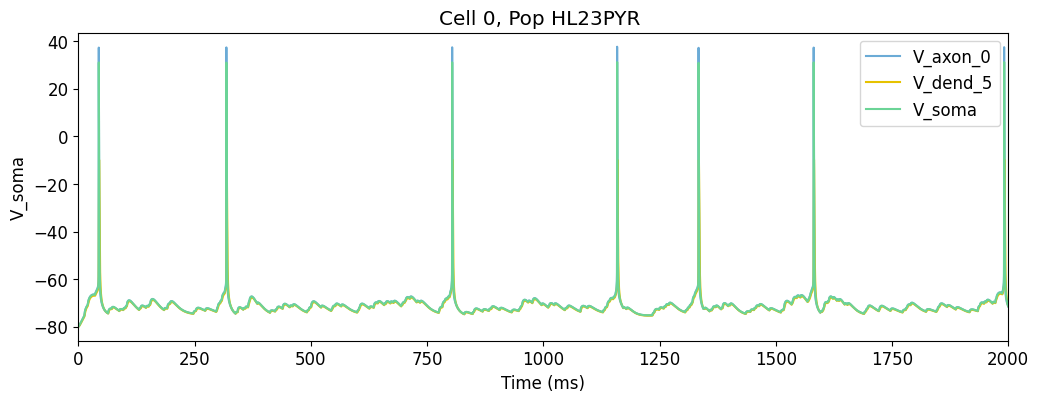

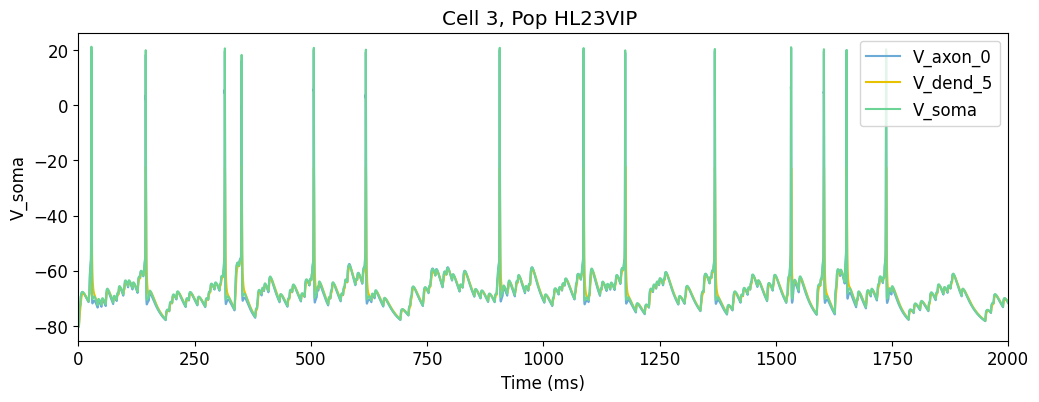

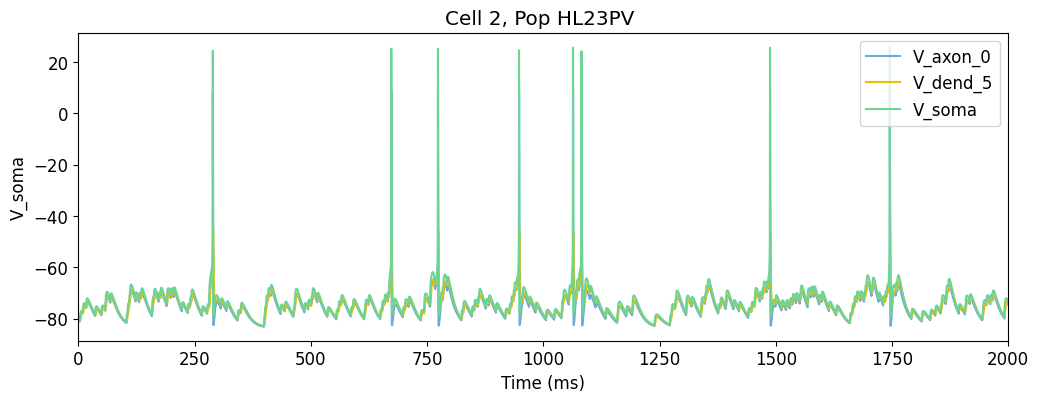

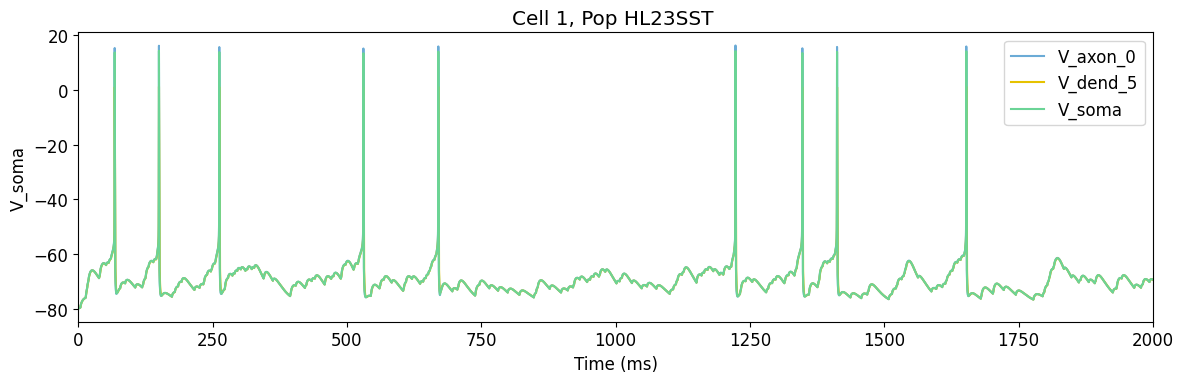

  Done; plotting time = 2.82 s

Total time = 12.41 s
Plotting 3D cell shape ...


(<Figure size 640x480 with 1 Axes>, {})

In [24]:
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc
sim.analysis.plotShape()  

Preparing spike data...
Plotting raster...


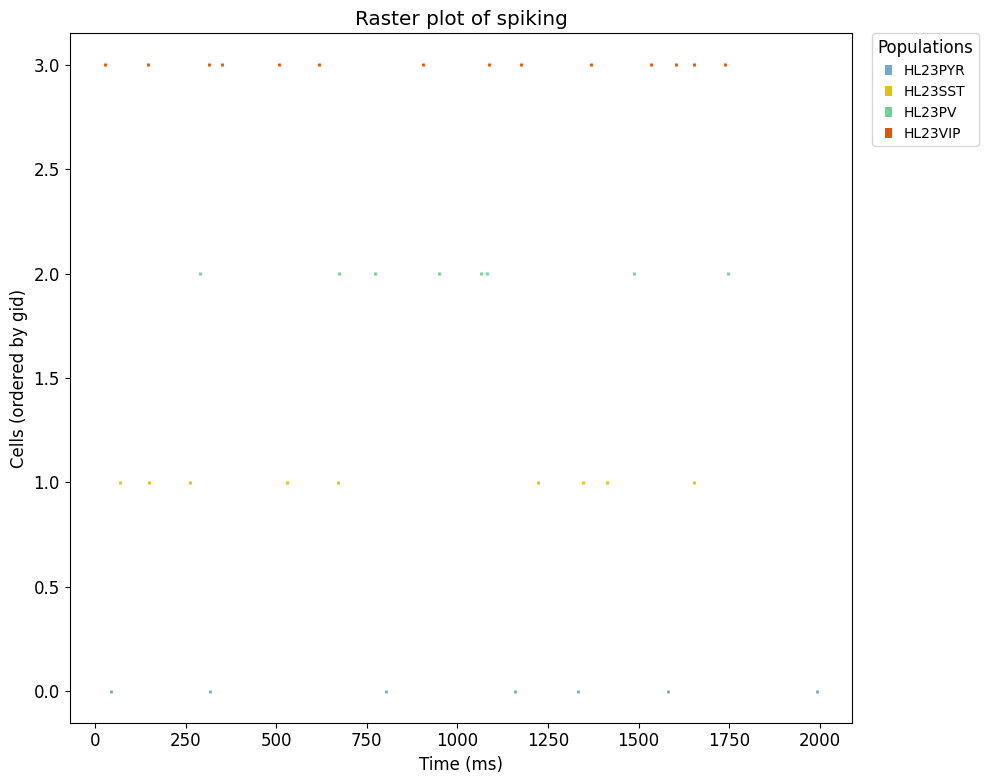

In [25]:
sim.analysis.plotRaster()

Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...


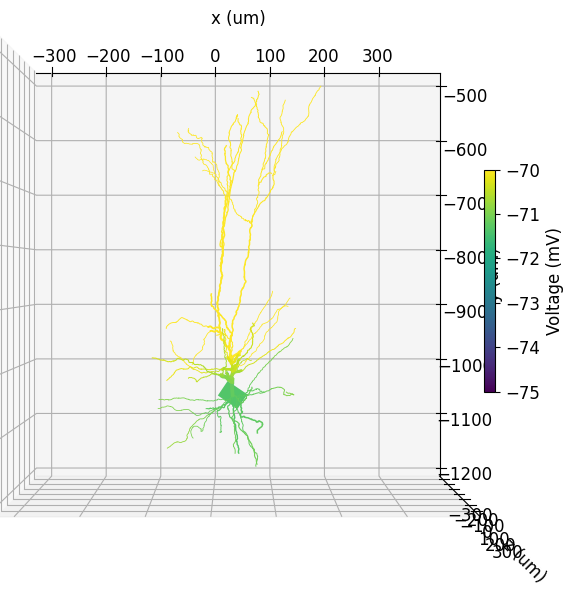

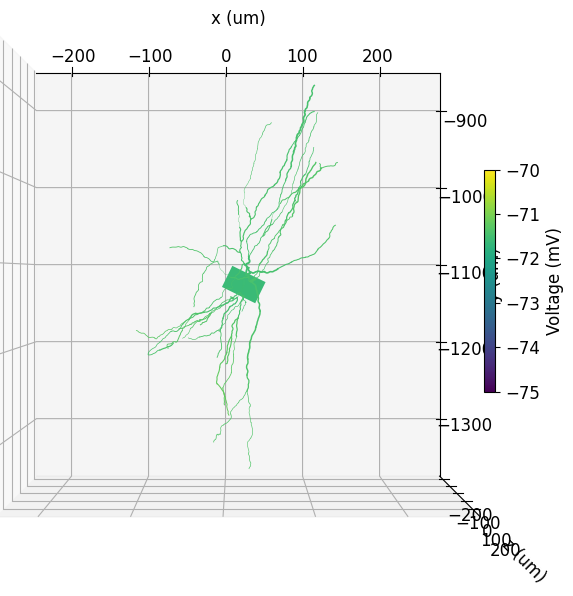

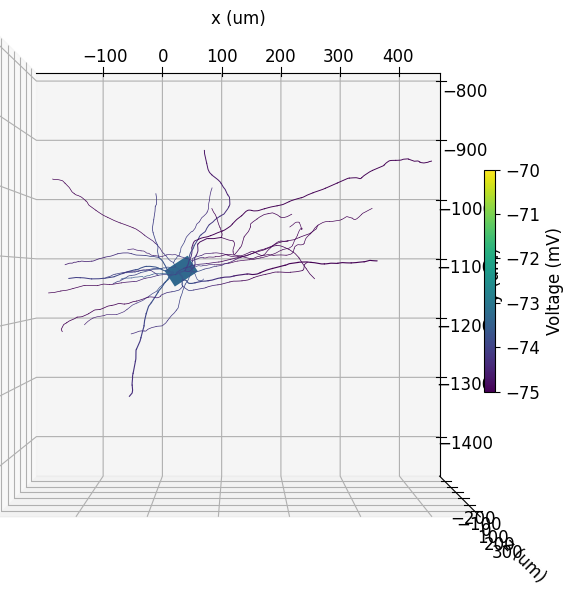

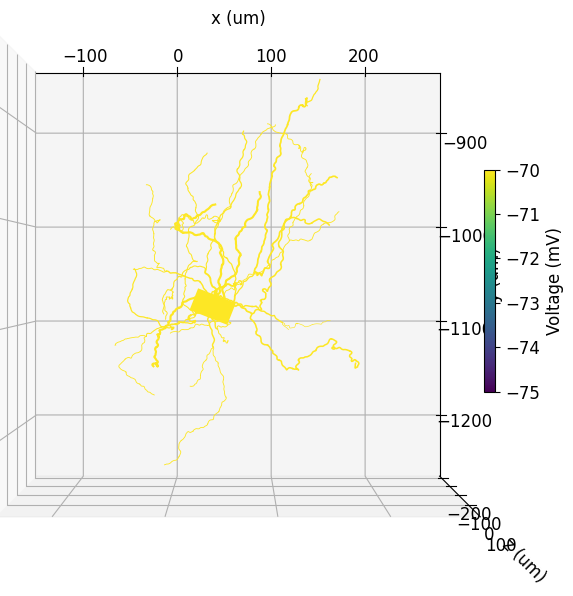

In [26]:
for cn,cell_name in enumerate(['HL23PYR', 'HL23VIP', 'HL23PV', 'HL23SST']):      
# for cn,cell_name in enumerate(['HL23PYR']):               

    sim.analysis.plotShape(includePre=[cell_name], includePost=[cell_name], includeAxon=False, showSyns=False, showElectrodes=False,
        cvar= 'voltage', dist=0.6, elev=90, azim=-90, 
        axisLabels=True, synStyle='o', 
        clim= [-75,-70], showFig=False, synSize=2)

Plotting recorded cell traces ... cell


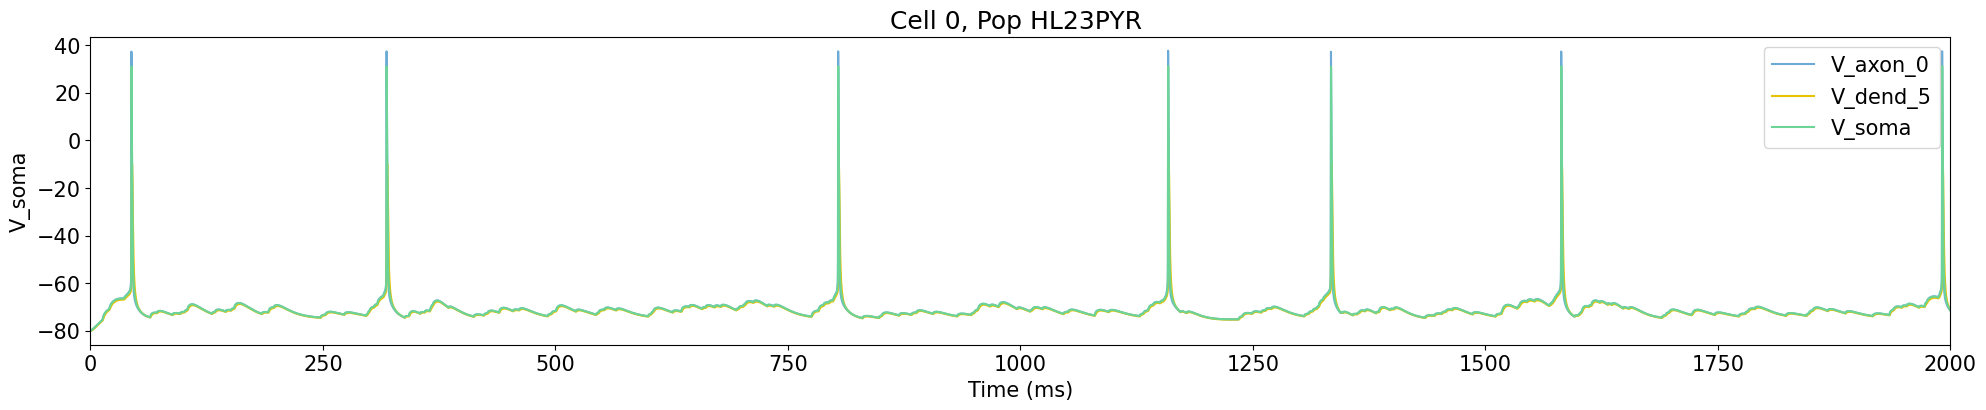

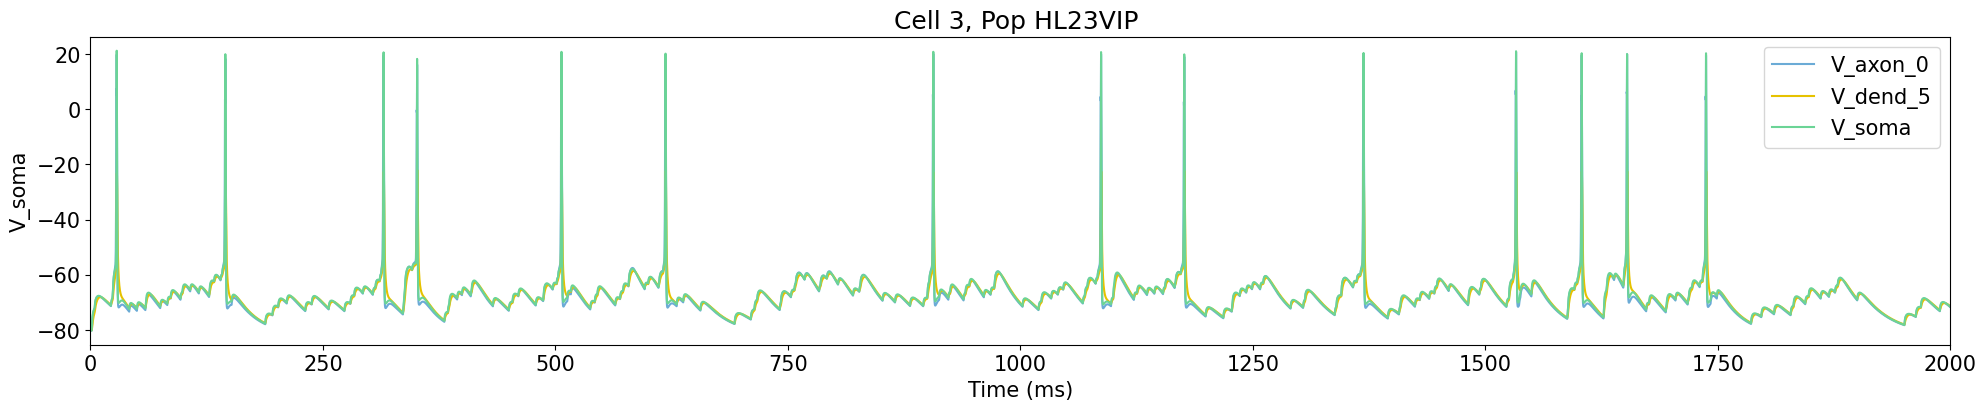

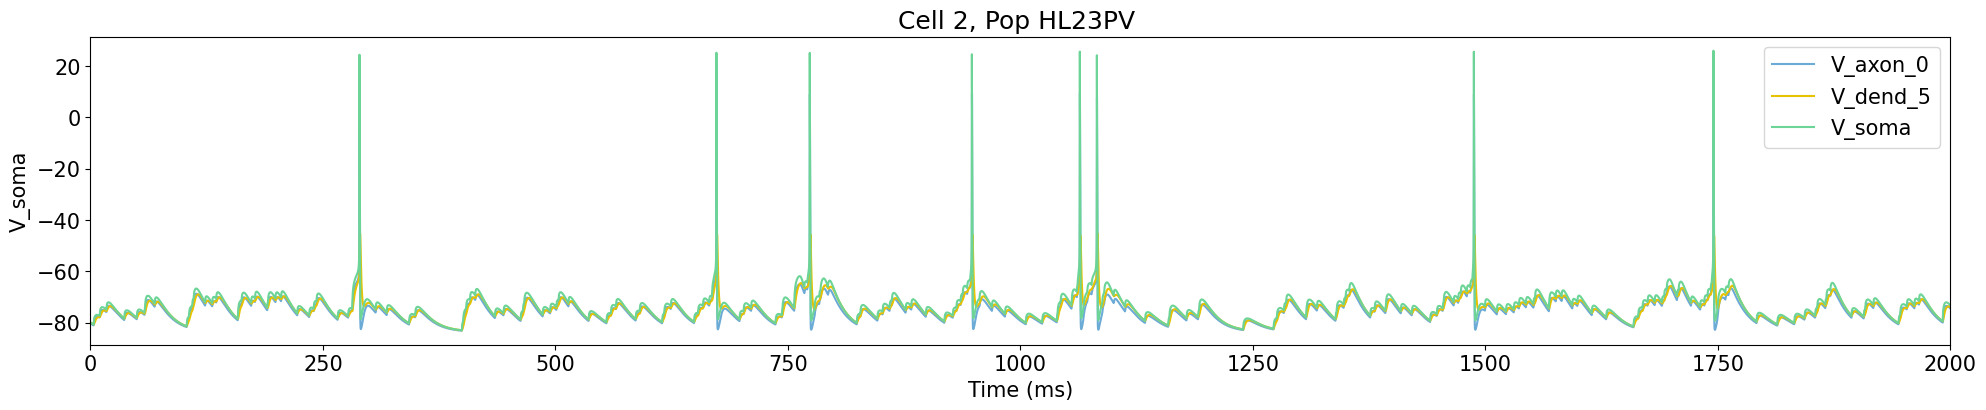

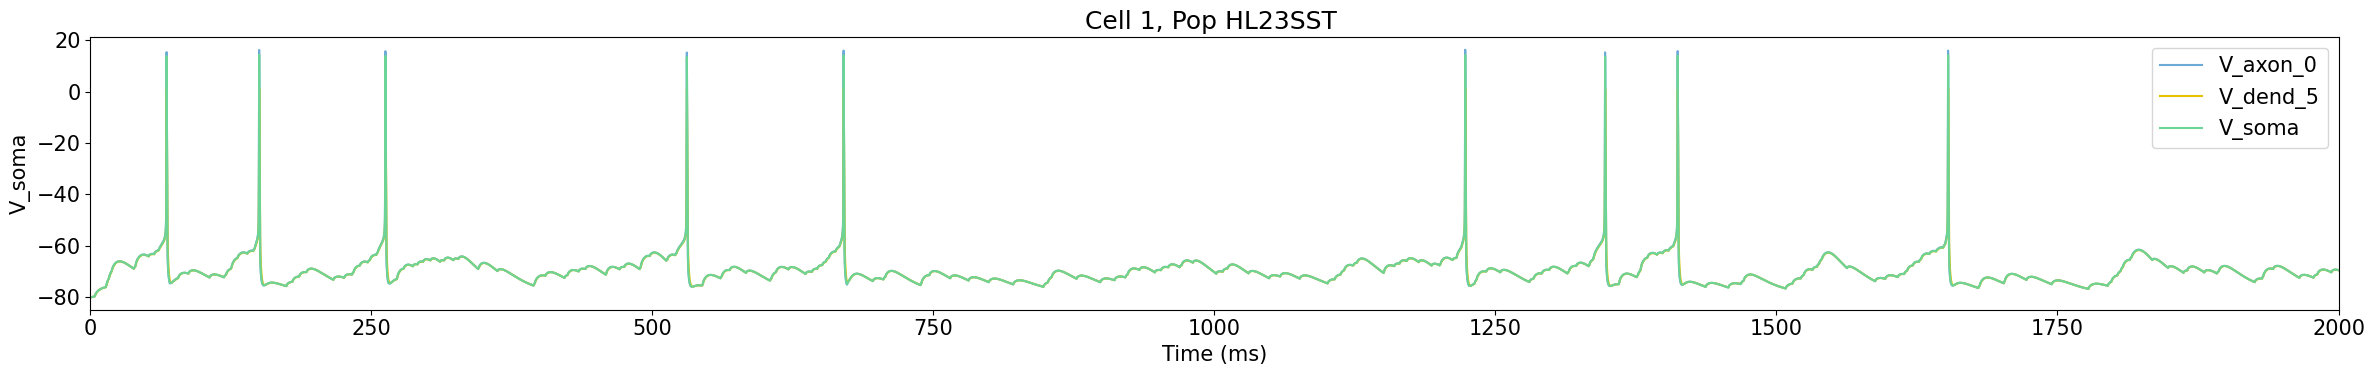

In [27]:
sim.analysis.plotTraces(overlay=True, timeRange=[0,cfg.duration], oneFigPer='cell', figSize=(24,4), fontSize=15, saveFig=False);

In [28]:
# for section in netParams.cellParams['HL23PYR_rule']['secLists']['all']:
#     print(section,'->',netParams.cellParams['HL23PYR_rule']['secs'][section]['topol']['parentSec'])
#     print(section,netParams.cellParams['HL23PYR_rule']['secs'][section]['geom']['diam'],netParams.cellParams['HL23PYR_rule']['secs'][section]['geom']['L'])

Plotting 2D representation of network cell locations and connections...


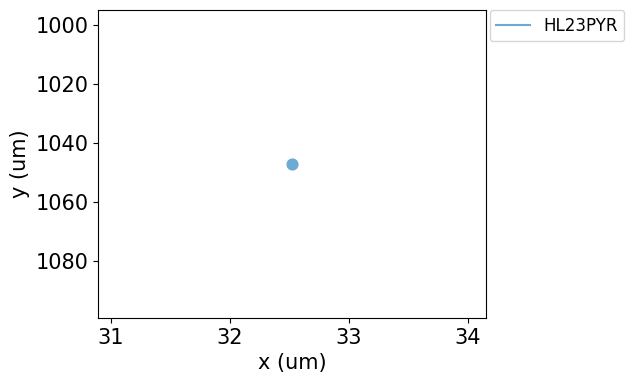

Plotting 2D representation of network cell locations and connections...


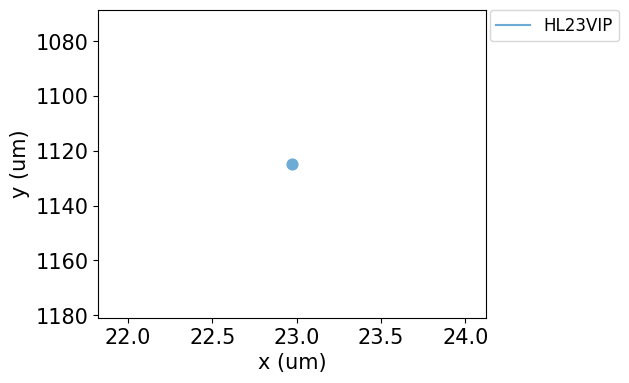

Plotting 2D representation of network cell locations and connections...


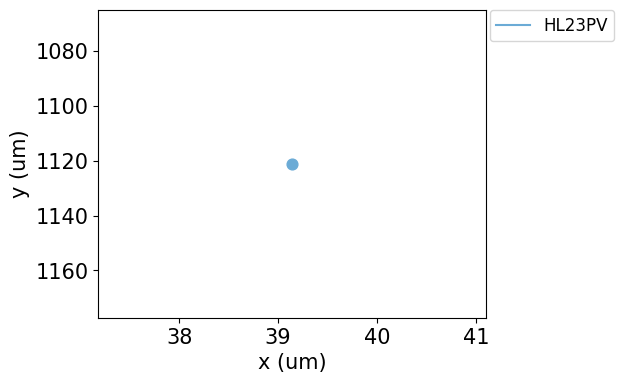

Plotting 2D representation of network cell locations and connections...


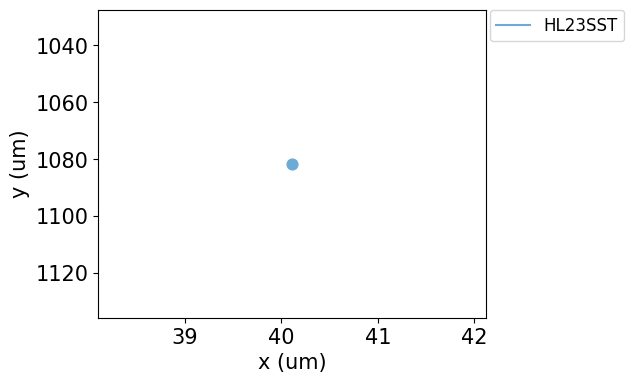

In [29]:
for cn,cell_name in enumerate(['HL23PYR', 'HL23VIP', 'HL23PV', 'HL23SST']):      
# for cn,cell_name in enumerate(['HL23PYR']):               

    sim.analysis.plot2Dnet(include=[cell_name], figSize=(5, 4), fontSize=12)

Plotting 2D representation of network cell locations and connections...


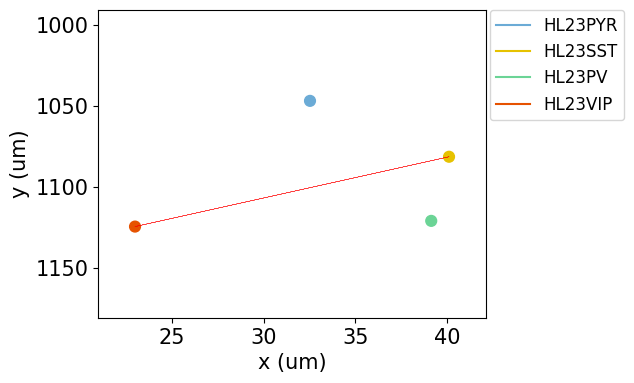

(<Figure size 500x400 with 1 Axes>,
 {'include': ['allCells'],
  'posX': [32.524030160228,
   40.112948969063,
   39.14114435166029,
   22.972636297931995],
  'posY': [1047.0976628719136,
   1081.576720024092,
   1121.1432041318287,
   1124.6653562121408],
  'posXpre': 22.972636297931995,
  'posXpost': 40.112948969063,
  'posYpre': 1124.6653562121408,
  'posYpost': 1081.576720024092})

In [30]:
sim.analysis.plot2Dnet(figSize=(5, 4), fontSize=12)